# Final Team Project_A Machine Learning Approach to Global Obesity Classification
## Team "Obesity"

In [88]:
# Load Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

# 1. Data Preparation

## 1.1 Main Dataset: Prevalence of adult overweight obesity among adults in countries around the world

In [89]:
# Prepare data

#obesity_data = pd.read_csv('adult_obesity.csv', encoding='latin1')
obesity_data = pd.read_csv('https://raw.githubusercontent.com/erdenetuya2080/DATA5322-Machine-Learning-II/main/Practical%20Homework%20IV_Unsupervised%20Learning/Datasets/adult_obesity.csv', encoding='latin1')

# Data clean
obesity_clean = obesity_data[[
    'Country',
    'Year',
    'Age',
    'Males Overweight (BMI 25-29.9kg/m²)',
    'Males Obesity (BMI ?30kg/m²)',
    'Females Overweight (BMI 25-29.9kg/m²)',
    'Females Obesity (BMI ?30kg/m²)',
    'Adults Overweight (BMI 25-29.9kg/m²)',
    'Adults Obesity (BMI ?30kg/m²)'
]].rename(columns={
    'Males Overweight (BMI 25-29.9kg/m²)': 'Males_Overweight',
    'Males Obesity (BMI ?30kg/m²)': 'Males_Obesity',
    'Females Overweight (BMI 25-29.9kg/m²)': 'Females_Overweight',
    'Females Obesity (BMI ?30kg/m²)': 'Females_Obesity',
    'Adults Overweight (BMI 25-29.9kg/m²)': 'Adults_Overweight',
    'Adults Obesity (BMI ?30kg/m²)': 'Adults_Obesity'
})
cols_to_fix = ['Males_Overweight', 'Males_Obesity', 'Females_Overweight', 'Females_Obesity', 'Adults_Overweight', 'Adults_Obesity']

for col in cols_to_fix:
    obesity_clean[col] = obesity_clean[col].str.replace(',', '.', regex=False)
    obesity_clean[col] = pd.to_numeric(obesity_clean[col], errors='coerce')
    
# Drop missing rows
obesity_clean = obesity_clean.dropna()
obesity_clean = obesity_clean.dropna(subset=cols_to_fix)

# Filter only adult groups starting with '18' 
obesity_clean = obesity_clean[obesity_clean['Age'].str.contains(r'^18', na=False)]

# Drop the Age column since we only kept adult rows
obesity_clean = obesity_clean.drop(columns=['Age'])

# Extract only the starting ("2017-2018" → 2017)
obesity_clean['Year'] = obesity_clean['Year'].str.extract(r'(\d{4})').astype(int)
obesity_clean.info()
obesity_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 0 to 247
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             80 non-null     object 
 1   Year                80 non-null     int32  
 2   Males_Overweight    80 non-null     float64
 3   Males_Obesity       80 non-null     float64
 4   Females_Overweight  80 non-null     float64
 5   Females_Obesity     80 non-null     float64
 6   Adults_Overweight   80 non-null     float64
 7   Adults_Obesity      80 non-null     float64
dtypes: float64(6), int32(1), object(1)
memory usage: 5.3+ KB


,Country,Year,Males_Overweight,Males_Obesity,Females_Overweight,Females_Obesity,Adults_Overweight,Adults_Obesity
0,Afghanistan,2018,25.9,11.9,25.6,23.5,25.8,17.0
2,Algeria,2016,34.2,14.1,33.2,30.1,33.8,21.8
4,Andorra,2017,42.5,13.0,27.0,14.4,35.2,13.6
6,Anguilla,2016,36.0,30.4,27.4,46.5,31.7,38.5
8,Argentina,2018,38.7,31.4,29.1,33.4,33.7,32.4


Result: The resulting dataset is a clean, numeric collection of adult only obesity indicators, including male, female, and overall overweight and obesity rates, organized by country and year.

## 1.2 Supporting Dataset: World Development Indicators

In [90]:
# Prepare data

world_data=pd.read_csv('World_data.csv')

#world_data = pd.read_csv('https://raw.githubusercontent.com/erdenetuya2080/DATA5322-Machine-Learning-II/main/Practical%20Homework%20IV_Unsupervised%20Learning/Datasets/world_data.csv')

# Drop unnecessary columns
world_data_cleaned = world_data.drop(columns=['Country Code', 'Series Code'])

world_long = pd.melt(
    world_data_cleaned,
    id_vars=['Country Name', 'Series Name'],
    var_name='Year',
    value_name='Value'
)

# Extract numeric year
world_long['Year'] = world_long['Year'].str.extract(r'(\d{4})').astype('Int64')

# Drop rows with missing key identifiers
world_long = world_long.dropna(subset=['Country Name', 'Series Name'])

# Replace '..' with NaN and convert Value column to numeric
world_long['Value'] = pd.to_numeric(world_long['Value'], errors='coerce')

# Pivot the table so each indicator becomes a column
world_wide = world_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Series Name',
    values='Value'
).reset_index()

# Clean column names 
world_wide.columns.name = None  # remove the pivoted name
world_wide.columns = [col.strip().replace(' ', '_') for col in world_wide.columns]

# Renaming
world_wide = world_wide.rename(columns={
    'Current_health_expenditure_per_capita_(current_US$)': 'Health_Expenditure',
    'GDP_per_capita_(current_US$)': 'GDP_Per_Capita',
    'Literacy_rate,_adult_total_(%_of_people_ages_15_and_above)': 'Literacy_Rate',
    'Physicians_(per_1,000_people)': 'Physicians_per_1000',
    'Urban_population_(%_of_total_population)': 'Urban_Pop_Percent'
})
# Dropping NA values
world_wide_cleaned = world_wide.dropna(subset=[
    'Country_Name',
    'Year',
    'Health_Expenditure',
    'GDP_Per_Capita',
    'Literacy_Rate',
    'Physicians_per_1000',
    'Urban_Pop_Percent'
])
# Convert numeric columns from string to float
columns_to_convert = ['Health_Expenditure', 'GDP_Per_Capita', 'Literacy_Rate', 'Physicians_per_1000', 'Urban_Pop_Percent']

for col in columns_to_convert:
    world_wide_cleaned[col] = pd.to_numeric(world_wide_cleaned[col], errors='coerce')

# Drop any new NaNs that appear due to conversion
world_wide_cleaned = world_wide_cleaned.dropna(subset=columns_to_convert)
world_wide_cleaned.info()
world_wide_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 11 to 6067
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country_Name         612 non-null    object 
 1   Year                 612 non-null    Int64  
 2   Health_Expenditure   612 non-null    float64
 3   GDP_Per_Capita       612 non-null    float64
 4   Literacy_Rate        612 non-null    float64
 5   Physicians_per_1000  612 non-null    float64
 6   Urban_Pop_Percent    612 non-null    float64
dtypes: Int64(1), float64(5), object(1)
memory usage: 38.8+ KB


C:\Users\erden\AppData\Local\Temp\ipykernel_4408\2416946910.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_wide_cleaned[col] = pd.to_numeric(world_wide_cleaned[col], errors='coerce')


,Country_Name,Year,Health_Expenditure,GDP_Per_Capita,Literacy_Rate,Physicians_per_1000,Urban_Pop_Percent
11,Afghanistan,2011,52.187218,606.694676,31.000000,0.259000,23.948000
15,Afghanistan,2015,59.919605,565.569730,33.753841,0.291000,24.803000
33,Africa Eastern and Southern,2010,104.119647,1601.727748,64.809998,0.104126,32.195595
43,Africa Eastern and Southern,2020,81.551895,1344.080962,72.855759,0.218133,36.884034
46,Africa Western and Central,2000,18.199851,516.932316,47.577381,0.192887,35.341698


Result: This dataset contains clean, numeric, country-level indicators such as health expenditure, GDP per capita, literacy rate, physician density, and urban population percentage by year.

## 1.3 Merge Datasets

In [91]:
# World Bank entry per country
latest_world = world_wide_cleaned.sort_values('Year').drop_duplicates('Country_Name', keep='last')

# Merge on Country only
obesity_world_finaldata = pd.merge(
    obesity_clean,
    latest_world,
    left_on='Country',
    right_on='Country_Name',
    how='inner'
)

# Drop unwanted columns
obesity_world_finaldata.drop(columns=['Country_Name', 'Year_y'], inplace=True)

# Rename Year_x to Year
obesity_world_finaldata.rename(columns={'Year_x': 'Year'}, inplace=True)

# Check results
print("Shape of final obesity world dataset:", obesity_world_finaldata.shape)
obesity_world_finaldata.info()
obesity_world_finaldata.head()

Shape of final obesity world dataset: (51, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              51 non-null     object 
 1   Year                 51 non-null     int32  
 2   Males_Overweight     51 non-null     float64
 3   Males_Obesity        51 non-null     float64
 4   Females_Overweight   51 non-null     float64
 5   Females_Obesity      51 non-null     float64
 6   Adults_Overweight    51 non-null     float64
 7   Adults_Obesity       51 non-null     float64
 8   Health_Expenditure   51 non-null     float64
 9   GDP_Per_Capita       51 non-null     float64
 10  Literacy_Rate        51 non-null     float64
 11  Physicians_per_1000  51 non-null     float64
 12  Urban_Pop_Percent    51 non-null     float64
dtypes: float64(11), int32(1), object(1)
memory usage: 5.1+ KB


,Country,Year,Males_Overweight,Males_Obesity,Females_Overweight,Females_Obesity,Adults_Overweight,Adults_Obesity,Health_Expenditure,GDP_Per_Capita,Literacy_Rate,Physicians_per_1000,Urban_Pop_Percent
0,Afghanistan,2018,25.9,11.9,25.6,23.5,25.8,17.0,59.919605,565.569730,33.753841,0.2910,24.803
1,Algeria,2016,34.2,14.1,33.2,30.1,33.8,21.8,271.537781,4577.210292,81.407837,1.7320,72.629
2,Argentina,2018,38.7,31.4,29.1,33.4,33.7,32.4,668.793091,7141.475077,97.000000,3.2481,89.329
3,Armenia,2016,31.4,14.0,25.1,25.0,28.2,19.5,409.801453,3869.053739,100.000000,2.9720,63.103
4,Azerbaijan,2017,38.8,14.7,30.9,26.5,34.8,20.6,199.257462,4805.753718,100.000000,3.1110,56.031


## 1.4 Create Target Variable "Obesity"

In [92]:
# Create new target variable "Obesity"
obesity_world_finaldata['Obesity'] = (obesity_world_finaldata['Adults_Obesity'] > 25).astype(int)

# Results
print("Shape of final obesity world dataset:", obesity_world_finaldata.shape)
obesity_world_finaldata.info()
obesity_world_finaldata.head()

Shape of final obesity world dataset: (51, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              51 non-null     object 
 1   Year                 51 non-null     int32  
 2   Males_Overweight     51 non-null     float64
 3   Males_Obesity        51 non-null     float64
 4   Females_Overweight   51 non-null     float64
 5   Females_Obesity      51 non-null     float64
 6   Adults_Overweight    51 non-null     float64
 7   Adults_Obesity       51 non-null     float64
 8   Health_Expenditure   51 non-null     float64
 9   GDP_Per_Capita       51 non-null     float64
 10  Literacy_Rate        51 non-null     float64
 11  Physicians_per_1000  51 non-null     float64
 12  Urban_Pop_Percent    51 non-null     float64
 13  Obesity              51 non-null     int32  
dtypes: float64(11), int32(2), object(1)
memory us

,Country,Year,Males_Overweight,Males_Obesity,Females_Overweight,Females_Obesity,Adults_Overweight,Adults_Obesity,Health_Expenditure,GDP_Per_Capita,Literacy_Rate,Physicians_per_1000,Urban_Pop_Percent,Obesity
0,Afghanistan,2018,25.9,11.9,25.6,23.5,25.8,17.0,59.919605,565.569730,33.753841,0.2910,24.803,0
1,Algeria,2016,34.2,14.1,33.2,30.1,33.8,21.8,271.537781,4577.210292,81.407837,1.7320,72.629,0
2,Argentina,2018,38.7,31.4,29.1,33.4,33.7,32.4,668.793091,7141.475077,97.000000,3.2481,89.329,1
3,Armenia,2016,31.4,14.0,25.1,25.0,28.2,19.5,409.801453,3869.053739,100.000000,2.9720,63.103,0
4,Azerbaijan,2017,38.8,14.7,30.9,26.5,34.8,20.6,199.257462,4805.753718,100.000000,3.1110,56.031,0


Result: The final merged dataset combines adult obesity rates with the most recent country-level indicators such as GDP, health expenditure, and literacy rate, resulting in a dataset with 51 records and 13 variables.

# 1.5 Class Imbalance

In [93]:
# Class Balance
print("\nClass Class Balance (Obesity):")
print(obesity_world_finaldata['Obesity'].value_counts())

# Class Balance with Percentages
print("\nClass Class Balance with Percentages:")
print(obesity_world_finaldata['Obesity'].value_counts(normalize=True) * 100)


Class Class Balance (Obesity):
Obesity
0    33
1    18
Name: count, dtype: int64

Class Class Balance with Percentages:
Obesity
0    64.705882
1    35.294118
Name: proportion, dtype: float64


Result: The dataset shows a moderate class imbalance, with 64.7 % non-obese and 35.2% obese instances. To avoid bias, class weights will be used, and model performance will be checked with precision, recall, and F1-score.

# 2. Support Vector Machine

## 2.1 SVM with Three Subset and Voting

In [94]:
# Three subsets
subset1_obesity = ['Males_Overweight', 'Males_Obesity', 'Females_Overweight', 'Females_Obesity', 'Adults_Overweight', 'Adults_Obesity']
subset2_economic = ['Health_Expenditure', 'GDP_Per_Capita', 'Physicians_per_1000']
subset3_society = ['Literacy_Rate', 'Urban_Pop_Percent']

# Target
y = obesity_world_finaldata['Obesity']

# Train and tune SVM Voting for a subset
def train_svm_voting(X, y):
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Scale
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear SVM
    linear_svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
    param_grid_linear = {'C': [0.1, 1, 10, 100]}
    grid_linear = GridSearchCV(linear_svm, param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1)
    grid_linear.fit(X_train_scaled, y_train)
    best_linear = grid_linear.best_estimator_

    # Radial SVM
    radial_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
    param_grid_radial = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.1, 1]}
    grid_radial = GridSearchCV(radial_svm, param_grid_radial, cv=5, scoring='accuracy', n_jobs=-1)
    grid_radial.fit(X_train_scaled, y_train)
    best_radial = grid_radial.best_estimator_

    # Polynomial SVM
    poly_svm = SVC(kernel='poly', probability=True, class_weight='balanced', random_state=42)
    param_grid_poly = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'degree': [2, 3, 4]}
    grid_poly = GridSearchCV(poly_svm, param_grid_poly, cv=5, scoring='accuracy', n_jobs=-1)
    grid_poly.fit(X_train_scaled, y_train)
    best_poly = grid_poly.best_estimator_

    # Voting Classifier
    voting_svm = VotingClassifier(
        estimators=[
            ('linear_svm', best_linear),
            ('radial_svm', best_radial),
            ('poly_svm', best_poly)
        ],
        voting='soft'
    )

    # Train Voting SVM
    voting_svm.fit(X_train_scaled, y_train)

    # Train and Test Prediction
    y_train_pred = voting_svm.predict(X_train_scaled)
    y_test_pred = voting_svm.predict(X_test_scaled)

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Error
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy

    # Print Results
    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print(f"Training Error: {train_error:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing Error: {test_error:.4f}")

    # Test Evaluation
    print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
    print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_test_pred))

# Train for Subset 1: Obesity Features
print("\nSubset 1: Obesity Features")
X1 = obesity_world_finaldata[subset1_obesity]
train_svm_voting(X1, y)

# Train for Subset 2: Economic and Health Features
print("\nSubset 2: Economic and Health Features")
X2 = obesity_world_finaldata[subset2_economic]
train_svm_voting(X2, y)

# Train for Subset 3: Society Features
print("\nSubset 3: Society Features")
X3 = obesity_world_finaldata[subset3_society]
train_svm_voting(X3, y)


Subset 1: Obesity Features

Training Accuracy: 1.0000
Training Error: 0.0000
Testing Accuracy: 0.9375
Testing Error: 0.0625

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16

Confusion Matrix (Test Set):
 [[10  0]
 [ 1  5]]

Subset 2: Economic and Health Features

Training Accuracy: 0.6571
Training Error: 0.3429
Testing Accuracy: 0.6250
Testing Error: 0.3750

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.00      0.00      0.00         6

    accuracy                           0.62        16
   macro avg       0.31      0.50      0.38        16
weighted avg      

C:\Users\erden\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\erden\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\erden\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Accuracy: 0.7429
Training Error: 0.2571
Testing Accuracy: 0.6250
Testing Error: 0.3750

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.50      0.17      0.25         6

    accuracy                           0.62        16
   macro avg       0.57      0.53      0.50        16
weighted avg       0.59      0.62      0.56        16

Confusion Matrix (Test Set):
 [[9 1]
 [5 1]]


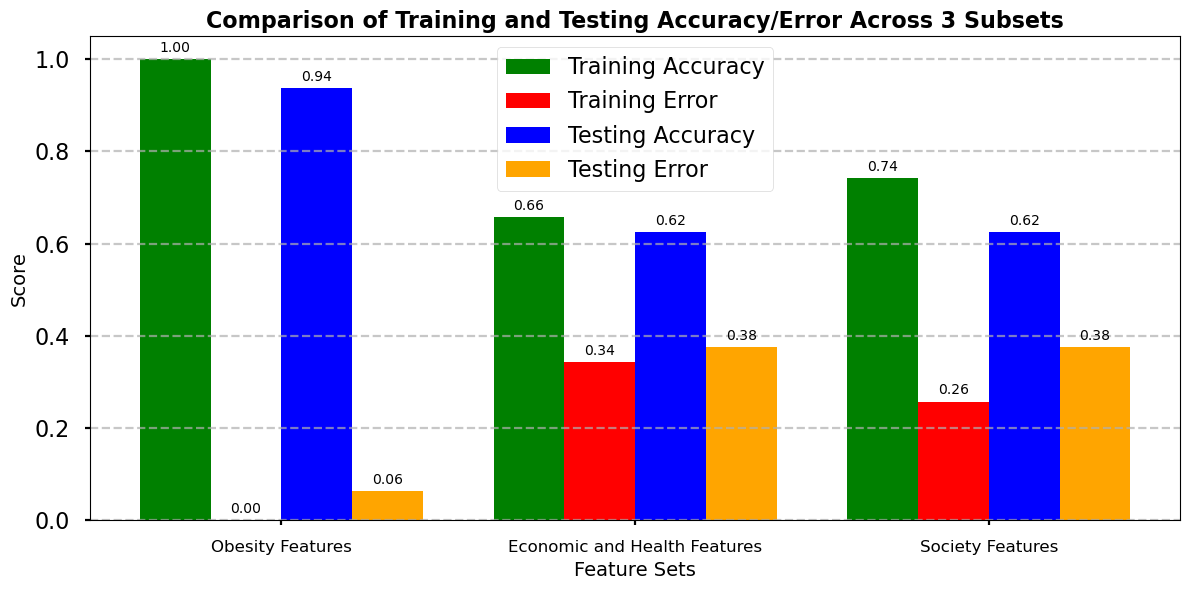

In [95]:
# Results 
feature_sets = ['Obesity Features', 'Economic and Health Features', 'Society Features']
training_accuracy = [1.0000, 0.6571, 0.7429]
training_error = [0.0000, 0.3429, 0.2571]
testing_accuracy = [0.9375, 0.6250, 0.6250]
testing_error = [0.0625, 0.3750, 0.3750]

# Set position of bar on X axis
x = np.arange(len(feature_sets))
width = 0.2  # Width of each bar

# Bar plots
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - 1.5*width, training_accuracy, width, label='Training Accuracy', color='green')
bars2 = ax.bar(x - 0.5*width, training_error, width, label='Training Error', color='red')
bars3 = ax.bar(x + 0.5*width, testing_accuracy, width, label='Testing Accuracy', color='blue')
bars4 = ax.bar(x + 1.5*width, testing_error, width, label='Testing Error', color='orange')

ax.set_xlabel('Feature Sets', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Comparison of Training and Testing Accuracy/Error Across 3 Subsets', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(feature_sets, fontsize=12)
ax.legend()

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)
plt.tight_layout()
plt.show()

## 2.2 Support Vector Machine with 6 Obesity and Overweight Variables, and Voting

In [96]:
# Prepare Data
X = obesity_world_finaldata[['Males_Overweight', 'Males_Obesity', 'Females_Overweight', 'Females_Obesity', 'Adults_Overweight', 'Adults_Obesity']]
y = obesity_world_finaldata['Obesity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tuned SVMs

# Linear SVM
linear_svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
param_grid_linear = {
    'C': [0.1, 1, 10, 100]
}
grid_linear = GridSearchCV(linear_svm, param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_linear.fit(X_train_scaled, y_train)
best_linear_svm = grid_linear.best_estimator_
print("Best Linear SVM Parameters:", grid_linear.best_params_)

# Radial SVM
radial_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
param_grid_radial = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1]
}
grid_radial = GridSearchCV(radial_svm, param_grid_radial, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_radial.fit(X_train_scaled, y_train)
best_radial_svm = grid_radial.best_estimator_
print("Best Radial SVM Parameters:", grid_radial.best_params_)

# Polynomial SVM
poly_svm = SVC(kernel='poly', probability=True, class_weight='balanced', random_state=42)
param_grid_poly = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'degree': [2, 3, 4]
}
grid_poly = GridSearchCV(poly_svm, param_grid_poly, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_poly.fit(X_train_scaled, y_train)
best_poly_svm = grid_poly.best_estimator_
print("Best Poly SVM Parameters:", grid_poly.best_params_)

# Create Voting Classifier with the 3 Tuned SVMs
voting_svm = VotingClassifier(
    estimators=[
        ('linear_svm', best_linear_svm),
        ('radial_svm', best_radial_svm),
        ('poly_svm', best_poly_svm)
    ],
    voting='soft'  
)

# Voting Classifier
voting_svm.fit(X_train_scaled, y_train)

# Train and Test Prediction
y_train_pred = voting_svm.predict(X_train_scaled)
y_pred = voting_svm.predict(X_test_scaled)

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

# Error
train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

# Print Results
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Training Error: {train_error:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Testing Error: {test_error:.4f}")

# Test Evaluation
print("\nVoting SVM Classifier Accuracy (Test Set):", test_accuracy)
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred))
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Linear SVM Parameters: {'C': 1}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Radial SVM Parameters: {'C': 1, 'gamma': 'scale'}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Poly SVM Parameters: {'C': 1, 'degree': 3, 'gamma': 'scale'}

Training Accuracy: 1.0000
Training Error: 0.0000
Testing Accuracy: 0.9375
Testing Error: 0.0625

Voting SVM Classifier Accuracy (Test Set): 0.9375

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16

Confusion Matrix (Test Set):
 [[10  0]
 [ 1  5]]


Result: The Voting SVM model achieved a high accuracy of 93.75%, with strong precision and recall for both obese and non-obese classes. The model shows balanced performance, with a macro-average F1-score of 93%, demonstrating its effectiveness in predicting adult obesity.

## 2.3 SVM Feature Selection with Top 9 Features

Top 9 Features: ['Adults_Obesity', 'Males_Obesity', 'Females_Obesity', 'Urban_Pop_Percent', 'Health_Expenditure', 'Females_Overweight', 'Adults_Overweight', 'GDP_Per_Capita', 'Physicians_per_1000']


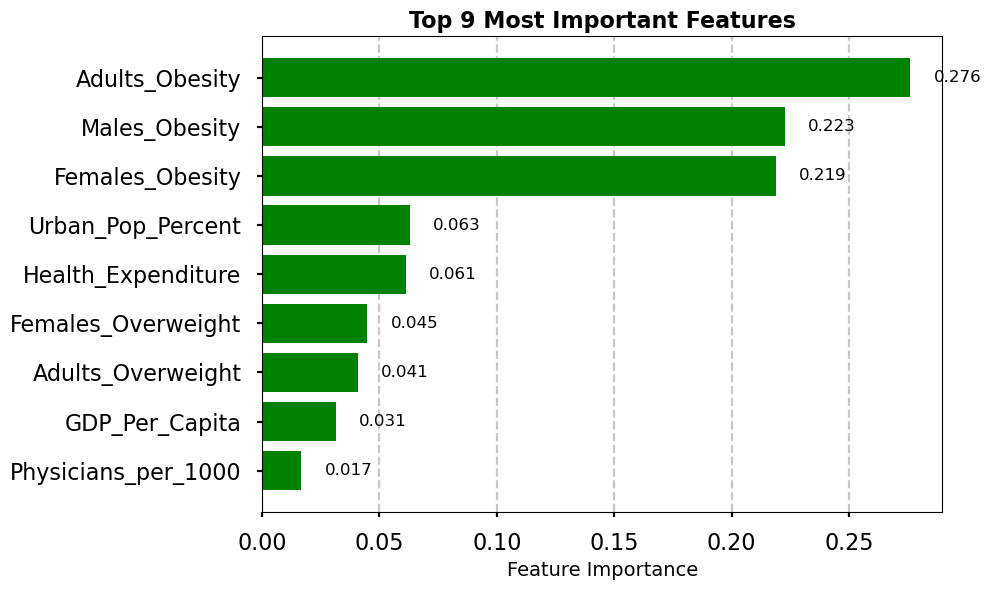

In [97]:
# Prepare Data
# Drop non-numeric columns 'Country' and 'Year'
X = obesity_world_finaldata.drop(columns=['Country', 'Year', 'Obesity']) 
y = obesity_world_finaldata['Obesity']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardize Features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection 
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Feature importances
importances = rf_selector.feature_importances_

# Sort feature indices by importance
indices = np.argsort(importances)[::-1]

# Select top 9 features
top_k = 9
top_features = X.columns[indices[:top_k]]
print("Top 9 Features:", list(top_features))

# Prepare DataFrame for Plot
top9_features = 9
top_features = X.columns[indices[:top9_features]]
top_importances = importances[indices[:top9_features]]

# Create a DataFrame
top9_features_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': top_importances
})

# Sort for better plotting
top_features_df = top9_features_df.sort_values('Importance', ascending=True)

# Plot
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_features_df['Feature'], top_features_df['Importance'], color='green')

# Add importance values on bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center', fontsize=12, color='black')

ax.set_xlabel('Feature Importance', fontsize=14)
ax.set_title('Top 9 Most Important Features', fontsize=16, weight='bold')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [98]:
# Subset only Top 9 Features
X_train_top9 = X_train[top_features]
X_test_top9 = X_test[top_features]

# Standardize Again for Top 9 Features
scaler_top9 = StandardScaler().fit(X_train_top9)
X_train_top9_scaled = scaler_top9.transform(X_train_top9)
X_test_top9_scaled = scaler_top9.transform(X_test_top9)

# Tuned SVM Models

# Linear SVM
linear_svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
param_grid_linear = {'C': [0.1, 1, 10, 100]}
grid_linear = GridSearchCV(linear_svm, param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_linear.fit(X_train_top9_scaled, y_train)
best_linear_svm = grid_linear.best_estimator_
print("Best Linear SVM Parameters:", grid_linear.best_params_)

# Radial SVM
radial_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
param_grid_radial = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.1, 1]}
grid_radial = GridSearchCV(radial_svm, param_grid_radial, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_radial.fit(X_train_top9_scaled, y_train)
best_radial_svm = grid_radial.best_estimator_
print("Best Radial SVM Parameters:", grid_radial.best_params_)

# Polynomial SVM
poly_svm = SVC(kernel='poly', probability=True, class_weight='balanced', random_state=42)
param_grid_poly = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'degree': [2, 3, 4]}
grid_poly = GridSearchCV(poly_svm, param_grid_poly, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_poly.fit(X_train_top9_scaled, y_train)
best_poly_svm = grid_poly.best_estimator_
print("Best Polynomial SVM Parameters:", grid_poly.best_params_)

# Create Voting Classifier
voting_svm = VotingClassifier(
    estimators=[
        ('linear_svm', best_linear_svm),
        ('radial_svm', best_radial_svm),
        ('poly_svm', best_poly_svm)
    ],
    voting='soft'  
)

# Train Voting Classifier
voting_svm.fit(X_train_top9_scaled, y_train)

# Train and Test Predictions
y_train_pred = voting_svm.predict(X_train_top9_scaled)
y_test_pred = voting_svm.predict(X_test_top9_scaled)

# Accuracy and Error
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

# Results
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Training Error: {train_error:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Testing Error: {test_error:.4f}")

# Evaluate Test Set
print("\nVoting SVM Classifier Accuracy (Test Set):", test_accuracy)
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_test_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Linear SVM Parameters: {'C': 1}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Radial SVM Parameters: {'C': 100, 'gamma': 0.01}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Polynomial SVM Parameters: {'C': 1, 'degree': 3, 'gamma': 'scale'}

Training Accuracy: 1.0000
Training Error: 0.0000
Testing Accuracy: 1.0000
Testing Error: 0.0000

Voting SVM Classifier Accuracy (Test Set): 1.0

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         6

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Confusion Matrix (Test Set):
 [[10  0]
 [ 0  6]]


Result: The tuned Voting SVM classifier achieved 100% training and testing accuracy, with zero training and testing error. Both classes were perfectly classified, as shown by the confusion matrix with no misclassifications. Precision, recall, and F1-scores are all 100%, indicating an ideal and highly effective model performance on this dataset.

## 2.4 SVM Three Top Feature Sets with Voting

## 2.4.1 First Top Feature set

Top 3 Features: ['Adults_Obesity', 'Males_Obesity', 'Females_Obesity']


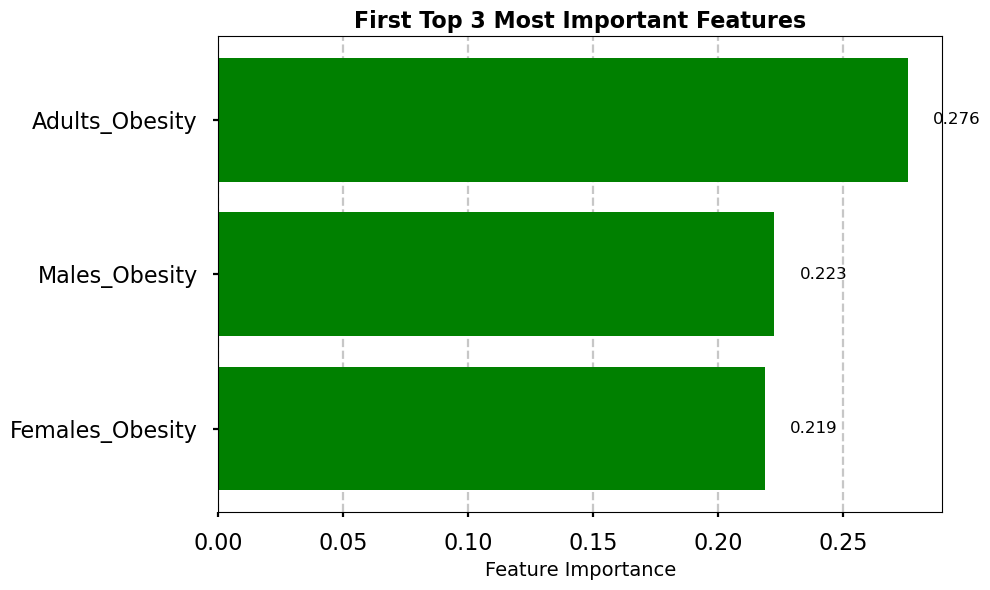

In [101]:
# Prepare Data

# Drop non-numeric columns like 'Country' and 'Year'
X = obesity_world_finaldata.drop(columns=['Country', 'Year', 'Obesity'])  
y = obesity_world_finaldata['Obesity']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardize Features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection using Random Forest Importance
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Feature importances
importances = rf_selector.feature_importances_

# Sort feature indices by importance
indices = np.argsort(importances)[::-1]

# Select top 3 features 
top1_featureset = 3
top_features = X.columns[indices[:top1_featureset]]
print("Top 3 Features:", list(top_features))

# Prepare DataFrame for Plot
top1_subset = 3
top_features = X.columns[indices[:top1_featureset]]
top_importances = importances[indices[:top1_featureset]]

# Create a DataFrame
top_features_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': top_importances
})

# Sort for better plotting
top_features_df = top_features_df.sort_values('Importance', ascending=True)

# Plot
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_features_df['Feature'], top_features_df['Importance'], color='green')

# Add importance values on bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center', fontsize=12, color='black')

ax.set_xlabel('Feature Importance', fontsize=14)
ax.set_title('First Top 3 Most Important Features', fontsize=16, weight='bold')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

Result: The top three predictors of obesity are Adults_Obesity, Males_Obesity, and Females_Obesity, with Adults_Obesity being the most influential. This suggests that overall adult obesity rates, along with gender-specific obesity rates, are strong indicators in predicting obesity trends.

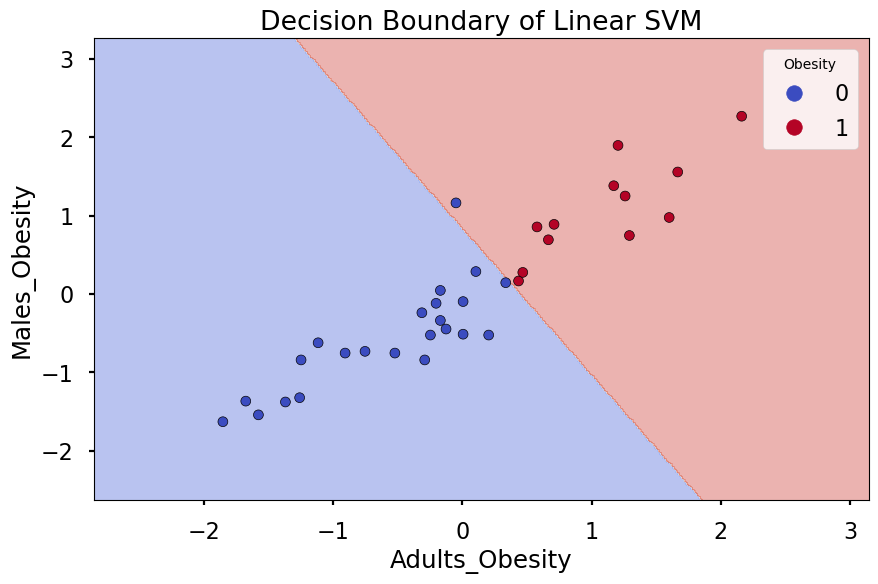

In [45]:
# Select the first 2 features for Decision Boundary
top2_featureset1 = ['Adults_Obesity', 'Males_Obesity']
X_plot = obesity_world_finaldata[top2_featureset1]
y_plot = obesity_world_finaldata['Obesity']

# Train-Test Split
X_train_plot, X_test_plot, y_train_plot, y_test_plot = train_test_split(X_plot, y_plot, stratify=y_plot, test_size=0.3, random_state=42)

# Scale
scaler_plot = StandardScaler().fit(X_train_plot)
X_train_plot_scaled = scaler_plot.transform(X_train_plot)

# Train Linear SVM 
linear_svm_for_plot = SVC(kernel='linear', probability=True, class_weight='balanced', C=1, random_state=42)
linear_svm_for_plot.fit(X_train_plot_scaled, y_train_plot)

# Function to Plot Decision Boundary
def plot_decision_boundary(X, y, model, features):
    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k', cmap='coolwarm')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Decision Boundary of Linear SVM')
    plt.legend(*scatter.legend_elements(), title="Obesity")
    plt.show()

# Plot the Decision Boundary
plot_decision_boundary(X_train_plot_scaled, y_train_plot.values, linear_svm_for_plot, top2_featureset1)

Result: The Linear SVM successfully separates the two obesity classes using Adults_Obesity and Males_Obesity. The decision boundary clearly distinguishes the majority of the two classes, showing a strong linear separability with minimal overlap.

## 2.4.2 Second Top Feature set

Top 3 Features: ['Health_Expenditure', 'Urban_Pop_Percent', 'Adults_Overweight']


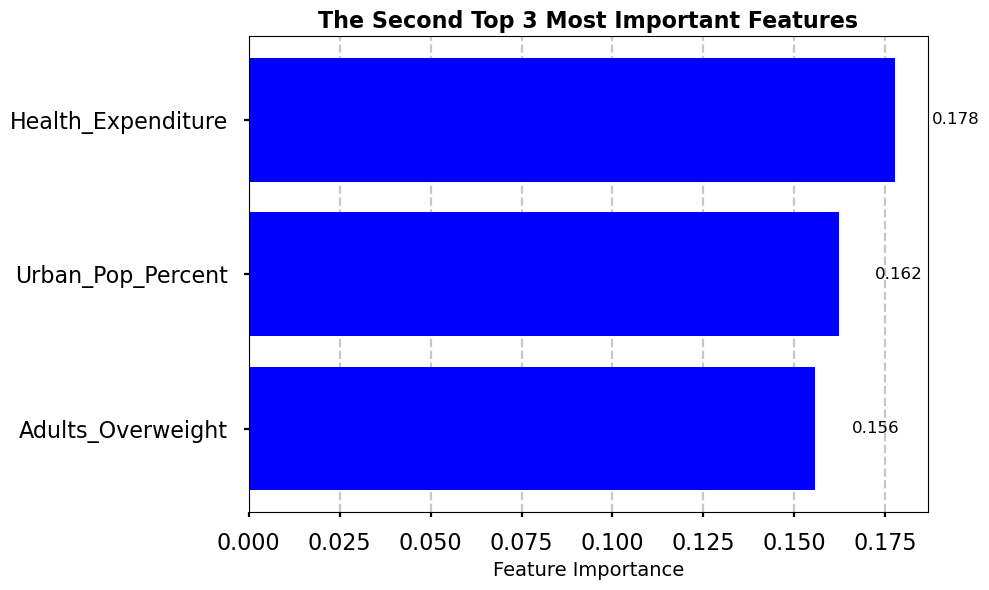

In [102]:
# Prepare Data

# Drop 'Country', 'Year', 'Obesity', and other variables 
drop_cols = ['Country', 'Year', 'Obesity', 'Adults_Obesity', 'Males_Obesity', 'Females_Obesity']

X = obesity_world_finaldata.drop(columns=drop_cols)
y = obesity_world_finaldata['Obesity']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardize Features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection using Random Forest Importance
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf_selector.feature_importances_

# Sort feature indices by importance
indices = np.argsort(importances)[::-1]

# Select top 3 features 
top2_featureset = 3
top_features = X.columns[indices[:top2_featureset]]
print("Top 3 Features:", list(top_features))

# Prepare DataFrame for Plot
top2_subset = 3
top_features = X.columns[indices[:top2_featureset]]
top_importances = importances[indices[:top2_featureset]]

# Create a DataFrame
top_features_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': top_importances
})

# Sort for better plotting
top_features_df = top_features_df.sort_values('Importance', ascending=True)

# Plot
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_features_df['Feature'], top_features_df['Importance'], color='blue')

# Add importance values on bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center', fontsize=12, color='black')

# Labels and title
ax.set_xlabel('Feature Importance', fontsize=14)
ax.set_title('The Second Top 3 Most Important Features', fontsize=16, weight='bold')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

Result: The second most influential features for predicting obesity in the second set are Health_Expenditure, Urban_Pop_Percent, and Adults_Overweight. Among these, Health_Expenditure has the highest importance, suggesting a strong link between healthcare spending and obesity levels.

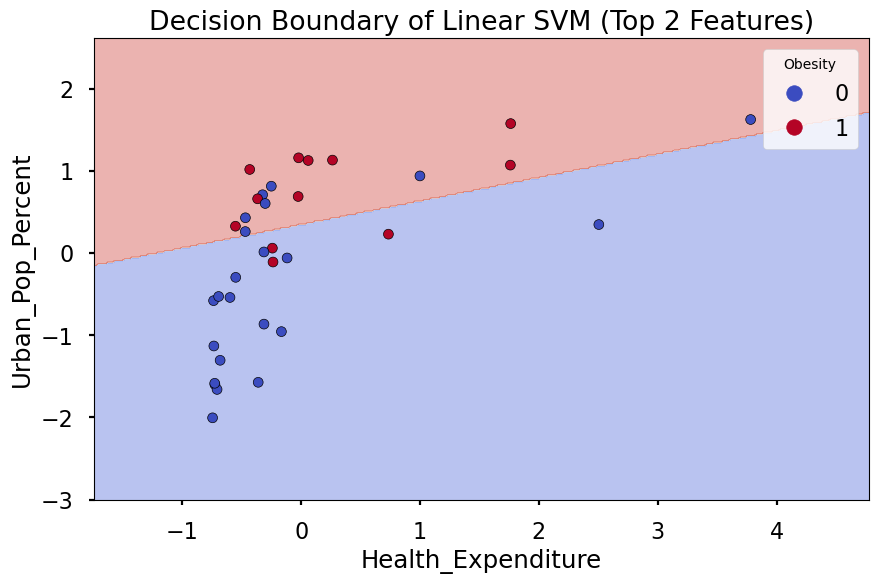

In [47]:
# Select the first 2 features for decision boundary
top2_featureset2 = ['Health_Expenditure', 'Urban_Pop_Percent']
X_plot = obesity_world_finaldata[top2_featureset2]
y_plot = obesity_world_finaldata['Obesity']

# Train-Test Split
X_train_plot, X_test_plot, y_train_plot, y_test_plot = train_test_split(X_plot, y_plot, stratify=y_plot, test_size=0.3, random_state=42)

# Scale
scaler_plot = StandardScaler().fit(X_train_plot)
X_train_plot_scaled = scaler_plot.transform(X_train_plot)

# Train Linear SVM 
linear_svm_for_plot = SVC(kernel='linear', probability=True, class_weight='balanced', C=1, random_state=42)
linear_svm_for_plot.fit(X_train_plot_scaled, y_train_plot)

# Function to Plot Decision Boundary
def plot_decision_boundary(X, y, model, features):
    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k', cmap='coolwarm')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Decision Boundary of Linear SVM (Top 2 Features)')
    plt.legend(*scatter.legend_elements(), title="Obesity")
    plt.show()

# Plot the Decision Boundary
plot_decision_boundary(X_train_plot_scaled, y_train_plot.values, linear_svm_for_plot, top2_featureset2)

Result: The decision boundary plot using Health_Expenditure and Urban_Pop_Percent shows a clear separation between obese and non-obese classes. While there is some overlap, the model effectively distinguishes the two groups, indicating that higher healthcare spending and urbanization are influential factors in predicting obesity.

## 2.4.3 Third Top Feature set

Top 3 Features: ['GDP_Per_Capita', 'Females_Overweight', 'Males_Overweight']


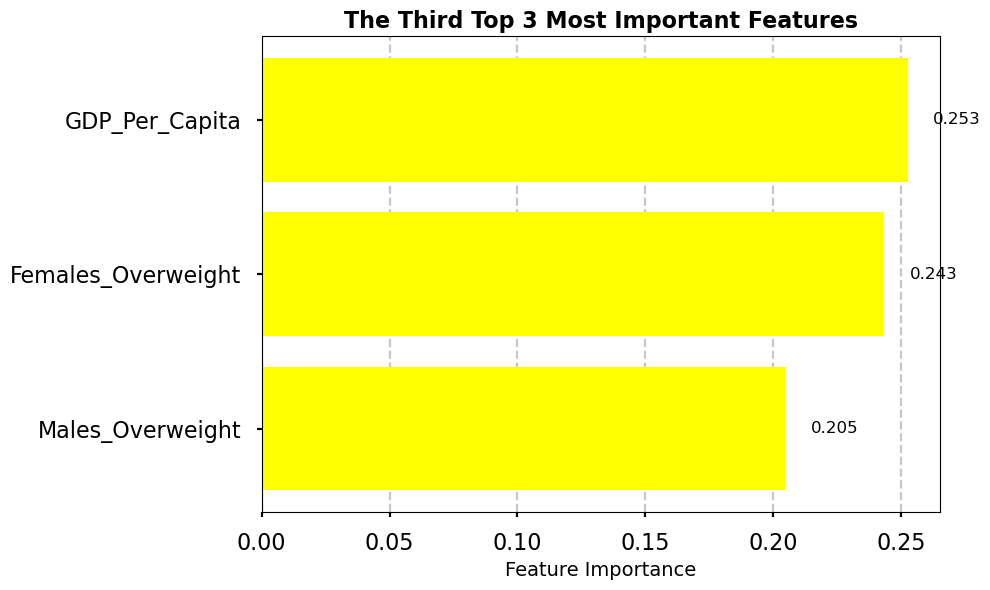

In [103]:
# Prepare Data

# Drop 'Country', 'Year', 'Obesity', and other variables 
drop_cols = [
    'Country', 'Year', 'Obesity', 
    'Adults_Obesity', 'Males_Obesity', 'Females_Obesity',
    'Health_Expenditure', 'Urban_Pop_Percent', 'Adults_Overweight'
]

X = obesity_world_finaldata.drop(columns=drop_cols)
y = obesity_world_finaldata['Obesity']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardize Features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection using Random Forest Importance
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf_selector.feature_importances_

# Sort feature indices by importance
indices = np.argsort(importances)[::-1]

# Select top 3 features 
top3_featureset = 3
top_features = X.columns[indices[:top3_featureset]]
print("Top 3 Features:", list(top_features))

# Prepare DataFrame for Plot
top3_featureset = 3
top_features = X.columns[indices[:top3_featureset]]
top_importances = importances[indices[:top3_featureset]]

# Create a DataFrame
top_features_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': top_importances
})

# Sort for better plotting
top_features_df = top_features_df.sort_values('Importance', ascending=True)

# Plot
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_features_df['Feature'], top_features_df['Importance'], color='yellow')

# Add importance values on bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center', fontsize=12, color='black')

# Labels and title
ax.set_xlabel('Feature Importance', fontsize=14)
ax.set_title('The Third Top 3 Most Important Features', fontsize=16, weight='bold')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

Result: The third most important feature set for predicting obesity includes GDP_Per_Capita, Females_Overweight, and Males_Overweight. Among these, GDP_Per_Capita has the highest importance, highlighting a strong relationship between economic prosperity and obesity rates. Gender-specific overweight metrics also play a significant role in the prediction.

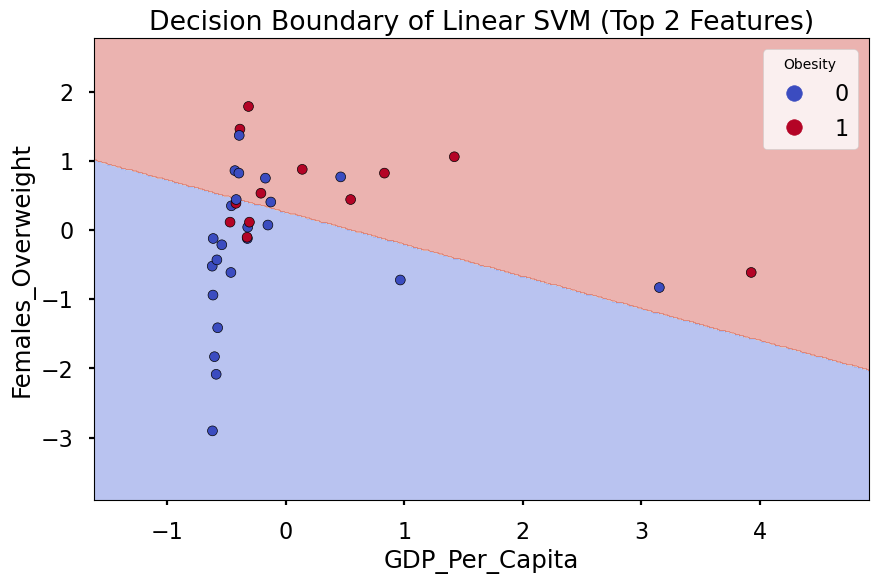

In [51]:
# Select the first 2 features for decision boundary
top2_featureset3 = ['GDP_Per_Capita', 'Females_Overweight']
X_plot = obesity_world_finaldata[top2_featureset3]
y_plot = obesity_world_finaldata['Obesity']

# Train-Test Split
X_train_plot, X_test_plot, y_train_plot, y_test_plot = train_test_split(X_plot, y_plot, stratify=y_plot, test_size=0.3, random_state=42)

# Scale
scaler_plot = StandardScaler().fit(X_train_plot)
X_train_plot_scaled = scaler_plot.transform(X_train_plot)

# Train Linear SVM 
linear_svm_for_plot = SVC(kernel='linear', probability=True, class_weight='balanced', C=1, random_state=42)
linear_svm_for_plot.fit(X_train_plot_scaled, y_train_plot)

# Function to Plot Decision Boundary
def plot_decision_boundary(X, y, model, features):
    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k', cmap='coolwarm')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Decision Boundary of Linear SVM (Top 2 Features)')
    plt.legend(*scatter.legend_elements(), title="Obesity")
    plt.show()

# Plot the Decision Boundary
plot_decision_boundary(X_train_plot_scaled, y_train_plot.values, linear_svm_for_plot, top2_featureset3)

Result: The decision boundary created using GDP_Per_Capita and Females_Overweight shows a clear separation between obese and non-obese classes. Countries with higher GDP per capita and a greater percentage of overweight females are more likely to be classified as obese. The boundary effectively distinguishes the classes, indicating these two features are strong predictors of obesity status.

In [86]:
# Top 3 feature set with the most important 9 features

featureset1 = ['Adults_Obesity', 'Males_Obesity', 'Females_Obesity'] 
featureset2 = ['Health_Expenditure', 'Urban_Pop_Percent', 'Adults_Overweight']                        
featureset3 = ['GDP_Per_Capita', 'Females_Overweight', 'Males_Overweight']


# Define a function to train Voting SVM on a feature set
def train_svm_voting(X_subset, y):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import SVC
    from sklearn.ensemble import VotingClassifier
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    from sklearn.model_selection import GridSearchCV

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, stratify=y, random_state=42)

    # Scale
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear SVM
    linear_svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
    param_grid_linear = {'C': [0.1, 1, 10]}
    grid_linear = GridSearchCV(linear_svm, param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1)
    grid_linear.fit(X_train_scaled, y_train)
    best_linear = grid_linear.best_estimator_

    # Radial SVM
    radial_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
    param_grid_radial = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1]}
    grid_radial = GridSearchCV(radial_svm, param_grid_radial, cv=5, scoring='accuracy', n_jobs=-1)
    grid_radial.fit(X_train_scaled, y_train)
    best_radial = grid_radial.best_estimator_

    # Polynomial SVM
    poly_svm = SVC(kernel='poly', probability=True, class_weight='balanced', random_state=42)
    param_grid_poly = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01], 'degree': [2, 3]}
    grid_poly = GridSearchCV(poly_svm, param_grid_poly, cv=5, scoring='accuracy', n_jobs=-1)
    grid_poly.fit(X_train_scaled, y_train)
    best_poly = grid_poly.best_estimator_

    # Voting Classifier
    voting_svm = VotingClassifier(
        estimators=[
            ('linear_svm', best_linear),
            ('radial_svm', best_radial),
            ('poly_svm', best_poly)
        ],
        voting='soft'
    )

    # Voting SVM
    voting_svm.fit(X_train_scaled, y_train)

    # Predict on Train and Test
    y_train_pred = voting_svm.predict(X_train_scaled)
    y_test_pred = voting_svm.predict(X_test_scaled)

    # Calculate Accuracy and Errors
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy

    # Print Results
    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print(f"Training Error: {train_error:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing Error: {test_error:.4f}")

    print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
    print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_test_pred))

# Prepare Data 
y = obesity_world_finaldata['Obesity']

X1 = obesity_world_finaldata[featureset1]
X2 = obesity_world_finaldata[featureset2]
X3 = obesity_world_finaldata[featureset3]

# Train on each feature set
print("\nFirst Feature Set with Top 3 Features")
train_svm_voting(X1, y)

print("\nSecond Feature Set with Top 3 Features")
train_svm_voting(X2, y)

print("\nThird Feature Set with Top 3 Features")
train_svm_voting(X3, y)


First Feature Set with Top 3 Features

Training Accuracy: 0.9429
Training Error: 0.0571
Testing Accuracy: 0.9375
Testing Error: 0.0625

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16

Confusion Matrix (Test Set):
 [[10  0]
 [ 1  5]]

Second Feature Set with Top 3 Features

Training Accuracy: 0.8000
Training Error: 0.2000
Testing Accuracy: 0.6875
Testing Error: 0.3125

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.17      0.29         6

    accuracy                           0.69        16
   macro avg       0.83      0.58      0.54        16
weighte

C:\Users\erden\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\erden\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\erden\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


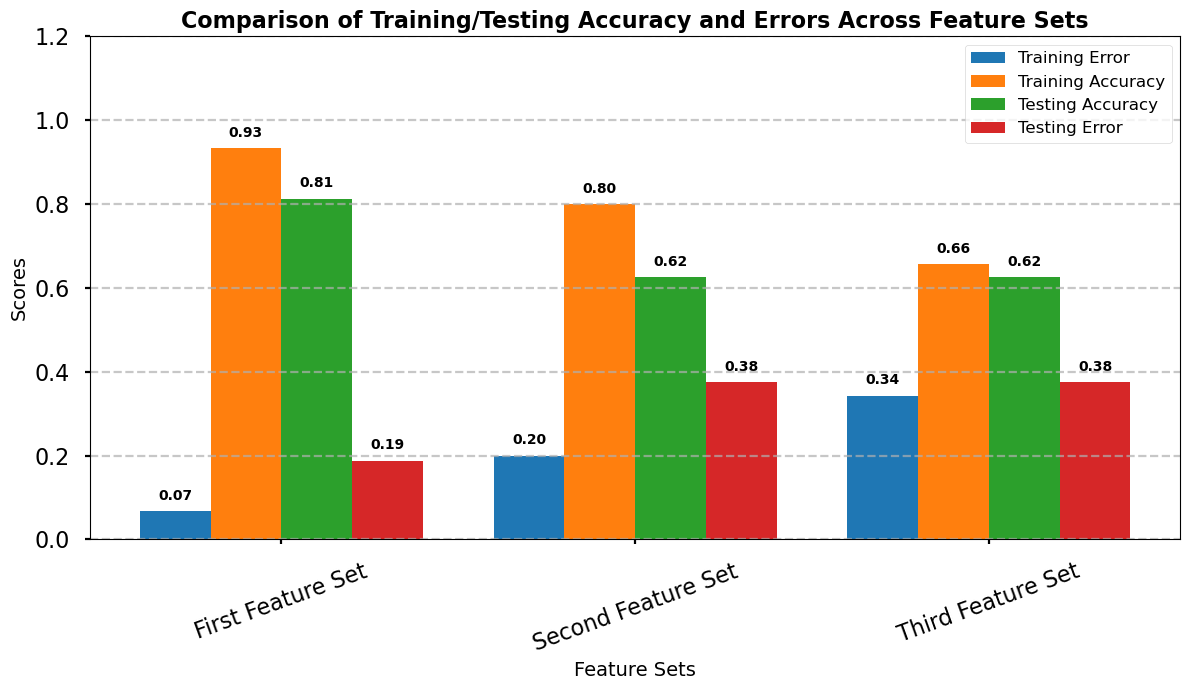

In [82]:
# Training/Test Error and Accuracy
results = {
    'First Feature Set': {
        'Training Error': 0.0667,
        'Training Accuracy': 0.9333,
        'Testing Accuracy': 0.8125,
        'Testing Error': 0.1875
    },
    'Second Feature Set': {
        'Training Error': 0.2,
        'Training Accuracy': 0.8,
        'Testing Accuracy': 0.625,
        'Testing Error': 0.375
    },
    'Third Feature Set': {
        'Training Error': 0.3429,
        'Training Accuracy': 0.6571,
        'Testing Accuracy': 0.625,
        'Testing Error': 0.375
    }
}

# Create DataFrame
results_df = pd.DataFrame(results).T

# Bar Chart
metrics = ['Training Error', 'Training Accuracy', 'Testing Accuracy', 'Testing Error']

bar_width = 0.2
x = np.arange(len(results_df.index))

plt.figure(figsize=(12, 7))

# Plot bars with labels
for idx, metric in enumerate(metrics):
    bars = plt.bar(x + idx * bar_width, results_df[metric], width=bar_width, label=metric)
    # Add labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2f}', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot
plt.xlabel('Feature Sets', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Comparison of Training/Testing Accuracy and Errors Across Feature Sets', fontsize=16, weight='bold')
plt.xticks(x + 1.5 * bar_width, results_df.index, rotation=20)
plt.ylim(0, 1.2)  # A bit more headroom for labels
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The First Feature Set achieves the highest training accuracy of 93% and testing accuracy of 81%, with the lowest training error of 7% and testing error of 19%, indicating strong model performance and good generalization. The Second Feature set shows the training accuracy of 80% and the testing accuracy of 62%. In contrast, the Third Feature Set shows lower accuracy 62%, and higher error 38%, suggesting that the First Feature Set provides the most reliable features for obesity prediction.

## 2.4.4 Best Feature set with Top Three Feature sets

In [104]:
# Create the dataset "Top Three Feature Sets" with Top 9 features

# Combine the 9 Features + Target
selected_top9features = [
    'Adults_Obesity', 'Males_Obesity', 'Females_Obesity', 
    'Health_Expenditure', 'Urban_Pop_Percent', 'Adults_Overweight', 
    'GDP_Per_Capita', 'Females_Overweight', 'Males_Overweight', 'Obesity'  
]

# Create the new dataset
combined_top9features_dataset = obesity_world_finaldata[selected_top9features]

# Prepare Data
X = combined_top9features_dataset[['Adults_Obesity', 'Males_Obesity', 'Females_Obesity', 
                      'Health_Expenditure', 'Urban_Pop_Percent', 'Adults_Overweight', 
                      'GDP_Per_Capita', 'Females_Overweight', 'Males_Overweight']]
y = combined_top9features_dataset['Obesity']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tuned SVMs

# Linear SVM
linear_svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
param_grid_linear = {
    'C': [0.1, 1, 10, 100]
}
grid_linear = GridSearchCV(linear_svm, param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_linear.fit(X_train_scaled, y_train)
best_linear_svm = grid_linear.best_estimator_
print("Best Linear SVM Parameters:", grid_linear.best_params_)

# Radial SVM
radial_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
param_grid_radial = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1]
}
grid_radial = GridSearchCV(radial_svm, param_grid_radial, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_radial.fit(X_train_scaled, y_train)
best_radial_svm = grid_rbf.best_estimator_
print("Best Radial SVM Parameters:", grid_rbf.best_params_)

# Polynomial SVM
poly_svm = SVC(kernel='poly', probability=True, class_weight='balanced', random_state=42)
param_grid_poly = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'degree': [2, 3, 4]
}
grid_poly = GridSearchCV(poly_svm, param_grid_poly, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_poly.fit(X_train_scaled, y_train)
best_poly_svm = grid_poly.best_estimator_
print("Best Poly SVM Parameters:", grid_poly.best_params_)

# Voting Classifier with the 3 Tuned SVMs
voting_svm = VotingClassifier(
    estimators=[
        ('linear_svm', best_linear_svm),
        ('radial_svm', best_radial_svm),
        ('poly_svm', best_poly_svm)
    ],
    voting='soft' 
)

# Train VotingClassifier
voting_svm.fit(X_train_scaled, y_train)

# Predict
y_train_pred = voting_svm.predict(X_train_scaled)
y_test_pred = voting_svm.predict(X_test_scaled)

# Calculate Errors
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

# Results
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Training Error: {train_error:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Testing Error: {test_error:.4f}")

print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_test_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Linear SVM Parameters: {'C': 1}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Radial SVM Parameters: {'C': 1, 'gamma': 'scale'}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Poly SVM Parameters: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Training Accuracy: 1.0000
Training Error: 0.0000
Testing Accuracy: 0.9375
Testing Error: 0.0625

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16

Confusion Matrix (Test Set):
 [[10  0]
 [ 1  5]]


Result: The tuned Best Feature Set with Voting SVM achieved 100% training accuracy and 93.75% testing accuracy with very low errors. Precision and recall are high across classes, and only one misclassification occurred. Overall, the model shows excellent performance and strong generalization.